# Clustering de texto

É um método de exploração de textos a partir das informações contidas nestes sem uma pré-classificação.
A preocupação desse método é como os textos estão divididos em relação a informação que eles possuem, mas sem uma pré-definição de como eles devem ser divididos, ou seja, esse método busca observar como os dados se comportam e a partir deles é proposto uma divisão.

Qual o ganho com o Clustering?
* Com as separações propostas, podemos observar quais textos são mais semelhantes um dos outros e coletar apenas os que são de interesse da pesquisa a partir do cluster.
* É possível observar um texto mediano do cluster, que "em tese" contém a informação mais próxima do que os textos daquele cluster apresentam.

## Inserção do _corpus_ de referência

Nessa seção, vamos olhar primeiro como inserir e transformar os textos de referência para o RAG.
* Leitura e tratamento de dados em pdf;
* Leitura de páginas de internet;

In [ ]:
%pip install pandas matplotlib seaborn scikit-learn xgboost lightgbm catboost mlflow optuna shap

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/18.5 MB ? eta -:--:--
   ---------------------------------------- 18.5/18.5 MB 117.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 141.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **Tratamento do _corpus_**

Agora que o _corpus_ já está em um formato que o Python entende, é necessário fazer os recortes dos textos, para separar as partes de informações que indicam o que é importante recuperar e o que não possui muita relação com a pergunta.

Entre as formas de recorte, temos das mais usuais até as mais engenhosas:

* Recortes com tamanho fixo _RecursiveCharacterTextSplitter_
* Recortes a partir de caractér específico _CharacterTextSplitter_
* Recortes utilizando catacterísticas semânticas _SemanticChunker_
* Recortes enriquecidos com "títulos" do texto

In [1]:
import pandas as pd

df = pd.read_csv('dataset_clinica20252.csv', sep='|')
docs = list(df.ds_fatos[:100])

In [10]:
df.head()

,cd_causa,cd_atendimento,ds_Acao_Judicial,ds_fatos,ds_Pedidos,ds_Qualificacao
0,CIB0500064,0825789-84.2025.8.18.0140,90 - ACAO DE REPARACAO DE DANOS,"DOS FATOS A parte Autora, pessoa idosa e hipos...","DOS PEDIDOS Ante ao exposto, requer: a) Sejam ...",DOUTO JUÍZO DE DIREITO DA ___ VARA CÍVEL DA CO...
1,CIB0505587,1004697-72.2025.8.26.0066,90 - ACAO DE REPARACAO DE DANOS,"DOS FATOS 5. A parte autora é pessoa idosa, hi...",DOS PEDIDOS E REQUERIMENTOS 33. Diante do expo...,(17) 99779-9177 / EXCELENTÍSSIMO SENHOR DOUTOR...
2,CIB0508201,0800423-07.2025.8.15.0761,90 - ACAO DE REPARACAO DE DANOS,DOS FATOS 1. SITUAÇÃO DE VULNERABILIDADE DO CO...,"DOS PEDIDOS E REQUERIMENTOS Ex Positis, requer...",AO COLENDO JUÍZO DA VARA ÚNICA DA COMARCA DE G...
3,CIB0514647,1004875-69.2025.8.26.0438,90 - ACAO DE REPARACAO DE DANOS,"DOS FATOS De plano, necessário esclarecer que ...","DOS PEDIDOS Diante do exposto, requer-se a Vos...","Avenida Eduardo de Castilho, n.o 315, Centro, ..."
4,CIB0500604,0010630-50.2025.8.27.2706,90 - ACAO DE REPARACAO DE DANOS,DOS FATOS A parte Requerente é correntista usu...,DOS PEDIDOS 1. QUE SEJA DEFERIDA A GRATUIDADE ...,AO DOUTO JUÍZO DA VARA CÍVEL DA COMARCA DE ARA...


In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)

# texts = text_splitter.split_documents(docs[0])
texts = text_splitter.split_text(docs[0])
print(texts[0])

DOS FATOS A parte Autora, pessoa idosa e hipossuficiente, é aposentada pelo INSS e percebe o valor mensal bruto de um salário mínimo. A Requerente recebe a referida quantia em seu cartão de conta corrente do referido Banco Requerido. Ocorre que desde janeiro de 2020, vem sendo descontado valores referente à GASTOS DE CARTÃO DE CRÉDITO imputado em sua conta corrente (EXTRATOS EM ANEXO). Acontece que a parte Autora não contratou e não utiliza cartão de crédito nenhum do banco Requerido, desconhecendo a origem dos descontos feitos por parte do Requerido. Ressalta-se, Vossa Excelência, que o único intuito da referida conta da parte Requerente é o recebimento e saque do seu benefício, conforme extratos da conta com as movimentações em anexo, e ao invés de ser fornecido uma conta benefício para o mesmo, foi aberta uma conta corrente em seu nome, utilizando-se de sua falta de conhecimentos técnicos. É importante ressaltar que a parte Requerente é pessoa idosa, de conhecimentos técnicos


Esse método é a forma mais simples de recorte de texto, ele busca tamanhos fixos de recorte e faz uma sobre prosição de texto entre os recortes. Esse método é muito útil quando a linguagem que está sendo utilizada possui algum padrão simples de pausa, final de sentença ou final de parágrafo.

Essa forma de recorte utiliza tamanhos máximos (_chunk size_), com separadores delimitados (no caso utilizamos uma quebra de linha) e _overlap_ de textos entre um recorte e outro (_chunk overlap_).
Essa forma pode ser bem útil quando possui separadores bem definidos (ex: expressões, nomes, capítulos e etc).

In [14]:
from langchain_text_splitters import CharacterTextSplitter
text_splitter = CharacterTextSplitter(
    separator=r"(fls. \d{1,3}/\d{1,3})",
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=True,
)
# texts = text_splitter.split_documents(docs[0])
texts = text_splitter.split_text(docs[0])
texts[0]

'DOS FATOS A parte Autora, pessoa idosa e hipossuficiente, é aposentada pelo INSS e percebe o valor mensal bruto de um salário mínimo. A Requerente recebe a referida quantia em seu cartão de conta corrente do referido Banco Requerido. Ocorre que desde janeiro de 2020, vem sendo descontado valores referente à GASTOS DE CARTÃO DE CRÉDITO imputado em sua conta corrente (EXTRATOS EM ANEXO). Acontece que a parte Autora não contratou e não utiliza cartão de crédito nenhum do banco Requerido, desconhecendo a origem dos descontos feitos por parte do Requerido. Ressalta-se, Vossa Excelência, que o único intuito da referida conta da parte Requerente é o recebimento e saque do seu benefício, conforme extratos da conta com as movimentações em anexo, e ao invés de ser fornecido uma conta benefício para o mesmo, foi aberta uma conta corrente em seu nome, utilizando-se de sua falta de conhecimentos técnicos. É importante ressaltar que a parte Requerente é pessoa idosa, de conhecimentos técnicos limit

Nos exemplos acima, primeiro fizemos o recorte de no máximo 1000 caractéres até quando houver uma quebra de linha. Já no segundo exemplo, fizemos o recorte pelo indicador de página do arquivo, ou seja, cada pedaço do texto é uma página do pdf.

In [16]:
from langchain_experimental.text_splitter import SemanticChunker
# from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

# embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
embeddings = HuggingFaceEmbeddings(model_name="rufimelo/bert-large-portuguese-cased-sts")

# text_splitter = SemanticChunker(embeddings, breakpoint_threshold_type="percentile", breakpoint_threshold=0.5)
text_splitter = SemanticChunker(embeddings, breakpoint_threshold_type="gradient", breakpoint_threshold_amount  = 0.5)
# text_splitter = SemanticChunker(embeddings, breakpoint_threshold_type="standard_deviation", breakpoint_threshold=0.5)

# texts = text_splitter.split_documents(docs[0])
texts = text_splitter.split_text(docs[0])
texts[0]

Invalid model-index. Not loading eval results into CardData.
Invalid model-index. Not loading eval results into CardData.


'DOS FATOS A parte Autora, pessoa idosa e hipossuficiente, é aposentada pelo INSS e percebe o valor mensal bruto de um salário mínimo.'

O método semântico leva em consideração a ordem das palavras, utilizando estatísticas para cada nova palavra no recorte. No caso, temos 3 métodos diferentes, o percentil (aonde a próxima palavra tem que tem um percentual de probabilidade acima de x% para poder ser considerado), o gradiente, que considera não somente a ultima palavra do recorte, mas todas as palavras do recorte e por fim o desvio padrão, que considera o quanto a palavra seguinte é diferente das demais do recorte.


## **Vetorização (Frequência de palavras)**

Dado os recortes de texto, é necessário transformar esses textos em sequência de números que permitem ser comparados. Uma forma mais simplista é observar a frequência de cada palavra nos textos e a mesma frequencia no corpus.

In [8]:
import nltk
# nltk.download('punkt_tab')  # Execute esta linha pelo menos uma vez para baixar o modelo
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


['Olá', '!', 'Este', 'é', 'um', 'exemplo', 'de', 'segmentação', 'de', 'sentenças', '.', 'O', 'NLTK', 'pode', 'dividir', 'textos', 'em', 'português', 'facilmente', '.']


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import nltk

# Download NLTK sentence tokenizer if not already present
# nltk.download('punkt')

# Example: split the first document in 'docs' into sentences
sentences = nltk.sent_tokenize(docs[0])
sentences

# Compute TF-IDF for each sentence
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(sentences)

# Compute the mean TF-IDF score for each sentence
mean_scores = np.asarray(tfidf_matrix.mean(axis=1)).flatten()

# Rank sentences by their mean TF-IDF score
ranked_sentences = [sentences[i] for i in mean_scores.argsort()[::-1]]

# Print the top 5 most "important" sentences
for i, sent in enumerate(ranked_sentences[:5]):
    print(f"Rank {i+1}: {sent}")

Rank 1: Ressalta-se, Vossa Excelência, que o único intuito da referida conta da parte Requerente é o recebimento e saque do seu benefício, conforme extratos da conta com as movimentações em anexo, e ao invés de ser fornecido uma conta benefício para o mesmo, foi aberta uma conta corrente em seu nome, utilizando-se de sua falta de conhecimentos técnicos.
Rank 2: É nítido que o Requerido se utilizou das peculiaridades da Requerente para imputar a mesma um cartão de crédito não contratado e do qual não faz o uso, descontando mensalmente valores consideráveis de sua conta corrente, acreditando que o Requerente não iria saber a origem do desconto, o que é um total descaso para o consumidor.
Rank 3: 2 Assinado eletronicamente por: LINDEMBERG FERREIRA SOARES CHAVES - 14/05/2025 16:37:18 Número do documento: 25051416371803600000070628782 INEXISTENTE, como restará provado com base nas provas anexas, assim como no mérito da questão.
Rank 4: TABELA COM VALORES DESCONTADOS A TÍTULO DE GASTOS DE CA

In [17]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(docs)
xtrain_tfidf =  tfidf_vect.transform(docs)
xvalid_tfidf =  tfidf_vect.transform(docs)
pd.DataFrame(xtrain_tfidf.toarray(), columns=tfidf_vect.get_feature_names_out()).head()

,0,00,000,0000,0000001,0000002,0000003,0001,0001593,0002610,...,óssea,ônibus,ônus,última,último,últimos,única,único,úteis,útil
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.048107,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.023888,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.031951,0.038489,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.118268,0.0,0.0


## **Vetorização (_embedding_)**

Dado os recortes de texto, é necessário transformar esses textos em sequência de números que permitem ser comparados. Como é necessário considerar a semântica do texto e não somente a freqüência das palavras, precisamos recorrer aos "_embeddings_", que atribui uma sequencia numérica para cada palavra e para cada recorte de texto.

In [27]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_experimental.text_splitter import SemanticChunker

# embeddings = HuggingFaceEmbeddings(model_name="rufimelo/bert-large-portuguese-cased-sts")

model_name = "rufimelo/bert-large-portuguese-cased-sts"
# model_kwargs = {'device': 'cpu'}
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs,
    )

embedding_vector = embeddings.embed_documents(docs)

# vector_store = InMemoryVectorStore(embeddings)
# text_splitter = SemanticChunker(embeddings, breakpoint_threshold_type="gradient", breakpoint_threshold_amount  = 0.5)

# texts = text_splitter.create_documents(docs)
# document_ids = vector_store.add_documents(documents=texts)
# texts[0]

Invalid model-index. Not loading eval results into CardData.
Invalid model-index. Not loading eval results into CardData.
Invalid model-index. Not loading eval results into CardData.


[-0.3481003940105438, -0.8226073980331421, 0.35034438967704773, -0.5188852548599243, 0.325966477394104, 0.19125080108642578, 0.27869847416877747, -0.4937231242656708, -0.1799914836883545, 0.04328729212284088, -0.5072916746139526, -0.9959406852722168, -0.3321230709552765, -0.2087881863117218, 0.05133147910237312, 0.34597092866897583, -0.07529120147228241, -0.06056426465511322, -0.1960592418909073, 0.5959059000015259, 0.10252609848976135, -0.044182565063238144, 0.0947074443101883, 0.4872032403945923, 0.32662153244018555, 0.18863028287887573, 0.06232176348567009, 0.17982105910778046, -0.37635791301727295, 0.1351553201675415, -0.4243520498275757, 0.5047022104263306, -0.9168486595153809, -0.758033037185669, -0.1989833116531372, -0.04532583802938461, -0.3325003683567047, 0.026887869462370872, -0.1635347157716751, -0.1112278401851654, -0.4888775646686554, 0.0027717379853129387, -0.2346966415643692, 0.13130493462085724, 0.8376962542533875, 0.20897258818149567, -0.04720345884561539, -0.20852105

Os embeddings são vetores numéricos que normalizam os textos/palavras, tornando eles comparáveis e possíveis de analogias. Um exemplo clássico é o vetor para "Rei" - "Homem" + "Mulher" = "Rainha". Esse tipo de comparação é possível devido a forma como os embeddings são criados, onde palavras que possuem significados semelhantes estão próximas uma da outra. No caso, estamos fazendo o embedding dos trechos de textos que temos, e não das palavras. Isso é importante para que possamos comparar os trechos de textos entre si e com a pergunta que será feita.

No exemplo acima, recortamos os textos das páginas do blog sobre _Machine_ _Learning_ em 425 recortes de texto diferentes, utilizando a métrica que observa a semantica dentro dos textos para fazer o recorte. Esses recortes irão servir como _input_ para o RAG, onde vamos comparar a pergunta feita com os recortes de texto, buscando aqueles que possuem uma maior semelhança com a pergunta. Esse método aumenta a acurácia da resposta, pois a AI generativa irá utilizar esses recortes para gerar a resposta, e não os textos completos ou os textos pré-treinados da AI.

## **Criação dos _Clusters_**

Agora já temos os textos que vamos usar, podemos pedir para o computador observar quantos clusters deveriamos ter na nossa base e em seguida formatar esses clusters

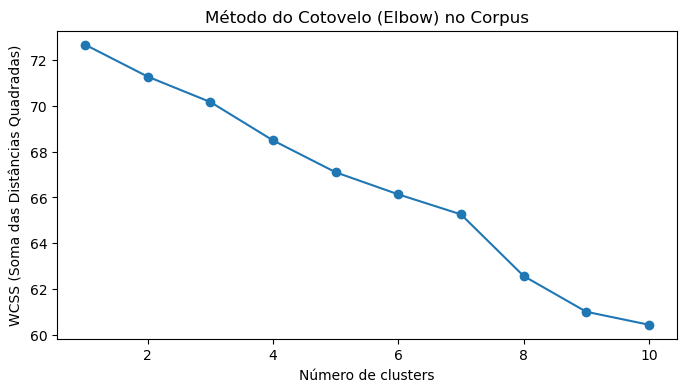

In [20]:
# Elbow method para definir o número ideal de clusters no corpus
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Exemplo: usando TF-IDF dos documentos do corpus
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
X = tfidf_vect.fit_transform(docs)

wcss = []
max_k = 10  # Número máximo de clusters a testar
for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, max_k+1), wcss, marker='o')
plt.title('Método do Cotovelo (Elbow) no Corpus')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS (Soma das Distâncias Quadradas)')
plt.show()

# O "cotovelo" do gráfico indica o número ideal de clusters para o corpus.

d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

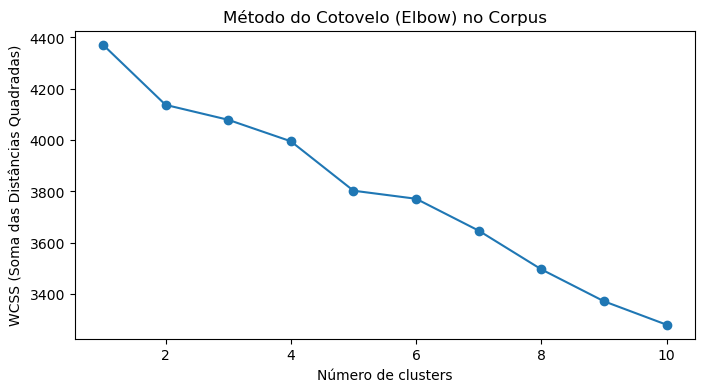

In [29]:
# Elbow method para definir o número ideal de clusters no corpus
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

X = embedding_vector

wcss = []
max_k = 10  # Número máximo de clusters a testar
for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, max_k+1), wcss, marker='o')
plt.title('Método do Cotovelo (Elbow) no Corpus')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS (Soma das Distâncias Quadradas)')
plt.show()

# O "cotovelo" do gráfico indica o número ideal de clusters para o corpus.

In [30]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Suppose 'texts' is your list of Document objects and 'embeddings' is your HuggingFaceEmbeddings instance

# Step 1: Get embeddings for each text chunk
X = embeddings.embed_documents(docs)  # shape: (n_texts, embedding_dim)

# Step 2: Cluster the embeddings
n_clusters = 5  # Choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Step 3: Find nearest neighbors for a given text
knn = NearestNeighbors(n_neighbors=3, metric='cosine')
knn.fit(X)
distances, indices = knn.kneighbors([X[0]])  # Find 3 nearest neighbors for the first text

print("Cluster labels:", labels)
print("Indices of nearest neighbors for first text:", indices)

Cluster labels: [2 2 4 3 2 2 3 4 4 1 1 1 2 2 2 2 2 1 0 0 4 4 2 2 4 4 0 3 2 2 4 4 2 2 4 4 3
 0 3 3 4 1 2 4 4 4 2 4 4 0 2 3 4 4 1 2 4 4 4 2 3 1 3 4 2 1 3 2 2 2 4 4 4 1
 2 3 4 3 4 1 1 2 1 4 1 2 2 0 4 4 3 3 2 2 4 2 1 4 4 4]
Indices of nearest neighbors for first text: [[ 0 99 81]]


d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [45]:
# Encontrar o texto mais "mediano" de cada cluster (mais próximo do centroide)
from scipy.spatial.distance import cdist

medians = []
for cluster_id in range(n_clusters):
    # Índices dos textos no cluster atual
    idxs = np.where(labels == cluster_id)[0]
    # Vetores dos textos do cluster
    cluster_vectors = [X[i] for i in idxs]
    # Centroide do cluster
    centroid = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    # Distâncias de cada texto ao centroide
    dists = cdist(cluster_vectors, centroid)
    # Índice do texto mais próximo do centroide
    med_idx = idxs[np.argmin(dists)]
    medians.append((cluster_id, docs[med_idx]))

for cluster_id, text in medians:
    print(f"Cluster {cluster_id}:\n{text}\n{'-'*60}")

Cluster 0:
O(a) requerente é correntista de longa data do BANCO BRADESCO S/A, tendo conta corrente nº 585738-4, agência 5792, há mais de 5 anos. É certo que o(a) requerente sempre zelou pela correta manutenção de sua conta corrente, impondo-se um rigoroso controle das finanças visando assegurar o sustento próprio e de sua família, assim como a satisfatória mantença do lar.  Ocorre que após a parte autora perceber em 09/03/2020 e 09/04/2021, cada vez mais a redução no valor de seu benefício, procurou sua agência bancária e lá foi informado (a) que o desconto era proveniente de um descontos denominado PAGTO ELETRON COBRANCA BRADESCO SEGUROS - RESIDENCIAL, serviço este nunca contratado pelo(a) requerente.  O desconto inesperado deixou a conta do(a) requerente com saldo negativo e lhe impossibilitou o adimplemento de suas despesas. Ademais o serviço PAGTO ELETRON COBRANCA BRADESCO SEGUROS - RESIDENCIAL, totalizou R$ 445,80 (quatrocentos e quarenta cinco reais e oitenta centavos).  Como o(a